## Imports and data loading

In [1]:
from joblib import dump, load

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import pickle
import xgboost as xgb
print(f'Pickle Version: {pickle.format_version}')

Pickle Version: 4.0


In [2]:
_pth_tst = '../data/test_2022-08-08.csv'
_pth_trn = '../data/train_2021-12-24.csv'
_pth_emb = '../data/embeddings.pkl'
_pth_enc ='../data/encoders.pkl'

train = pd.read_csv(_pth_trn)
test = pd.read_csv(_pth_tst)

with open(_pth_emb, 'rb') as handle:
    embeds = pickle.load(handle)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99586 entries, 0 to 99585
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sale_Price          99586 non-null  float64
 1   Odometer            99561 non-null  float64
 2   Power               99532 non-null  float64
 3   Fuel_Urban          88160 non-null  float64
 4   Make_Code           99586 non-null  object 
 5   Family_Code         99586 non-null  object 
 6   Year_Group          99586 non-null  int64  
 7   Region_Description  99586 non-null  object 
 8   Vehicle_Code        99586 non-null  int64  
 9   inventory_days      99586 non-null  int64  
 10  age_list_day        99586 non-null  int64  
 11  age_sell_day        99586 non-null  int64  
 12  sld_wknum           99586 non-null  int64  
 13  adv_wknum           99586 non-null  int64  
 14  km_per_day          99561 non-null  float64
 15  fuel_per_power      88160 non-null  float64
 16  odo_

## Retrive Encodings

In [4]:
feat_cols = ['Odometer', 'Power', 'Fuel_Urban', 'inventory_days', 
             'age_sell_day', 'km_per_day', 'fuel_per_power', 
             'odo_per_fuel', 'odo_per_power','pow_times_odo','sld_wknum','adv_wknum']

enc_cols = list(embeds)
enc_cols

['Make_Code', 'Family_Code', 'Region_Description']

In [5]:
def get_embedded_feat(feat, encod_dict, feat_name='Family_Code'):
    '''Return embeddings from feature column using encoded dict
    '''
    feat_df = feat.to_frame()
    encodings = encod_dict[feat_name].reset_index()
    feat_tranf = feat_df.merge(encodings, how='left', left_on=[feat_name], right_on=['index'], indicator=True)
    # print(feat_tranf._merge.value_counts())
    return feat_tranf.loc[:,[c for c in encodings.columns if c.startswith(feat_name)]]

In [6]:
embed_dflist = []
embed_dflist_test = []


for f in list(embeds):
    df = get_embedded_feat(train[f], embeds, feat_name=f)
    embed_dflist.append(df)
    df_test = get_embedded_feat(test[f], embeds, feat_name=f)
    embed_dflist_test.append(df_test)

In [7]:
X_train_df = pd.concat([train.loc[:,feat_cols]]+embed_dflist, axis=1)
y_train = train.loc[:,'Sale_Price']

X_test_df = pd.concat([test.loc[:,feat_cols]]+embed_dflist_test, axis=1)
y_test = test.loc[:,'Sale_Price']

In [8]:
X_train_df.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
Odometer,99561.0,80199.2,58443.5,0.0,37732.0,70832.0,111125.0,4000380.0
Power,99532.0,140.2,51.5,28.0,110.0,129.0,147.0,545.0
Fuel_Urban,88160.0,10.3,2.8,0.9,8.6,9.9,11.3,26.4
inventory_days,99586.0,35.0,38.2,0.0,14.0,26.0,45.0,2086.0
age_sell_day,99586.0,2191.6,1286.5,58.0,1268.2,1954.0,2882.0,9467.0
km_per_day,99561.0,36.5,20.7,0.0,23.2,34.1,46.6,2132.4
fuel_per_power,88160.0,0.1,0.0,0.0,0.1,0.1,0.1,0.2
odo_per_fuel,88139.0,7485.3,5578.7,0.0,3609.4,6640.4,10294.8,519529.9
odo_per_power,99507.0,637.6,517.1,0.0,270.0,530.3,876.5,28371.5
pow_times_odo,99507.0,11087809.7,9005382.5,0.0,4660709.0,9126640.0,15205012.5,564053580.0


In [19]:
# knn = KNNImputer()
# X_train = knn.fit_transform(X_train_df)
# X_test = knn.transform(X_test_df)
# dump(knn, 'knnimputer.joblib')

X_train = np.load('../out/X_train.npy')
X_test = np.load('../out/X_test.npy')

In [28]:
# load xg model

model = xgb.XGBRegressor()
model.load_model("../out/xgb_model.json")

## SHAPE explainer

In [21]:
import shap

In [29]:
Xtrain_df = pd.DataFrame(X_train, columns=X_train_df.columns)
Xtest_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [30]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xtest_df)
shap_values_tr = explainer.shap_values(Xtrain_df)

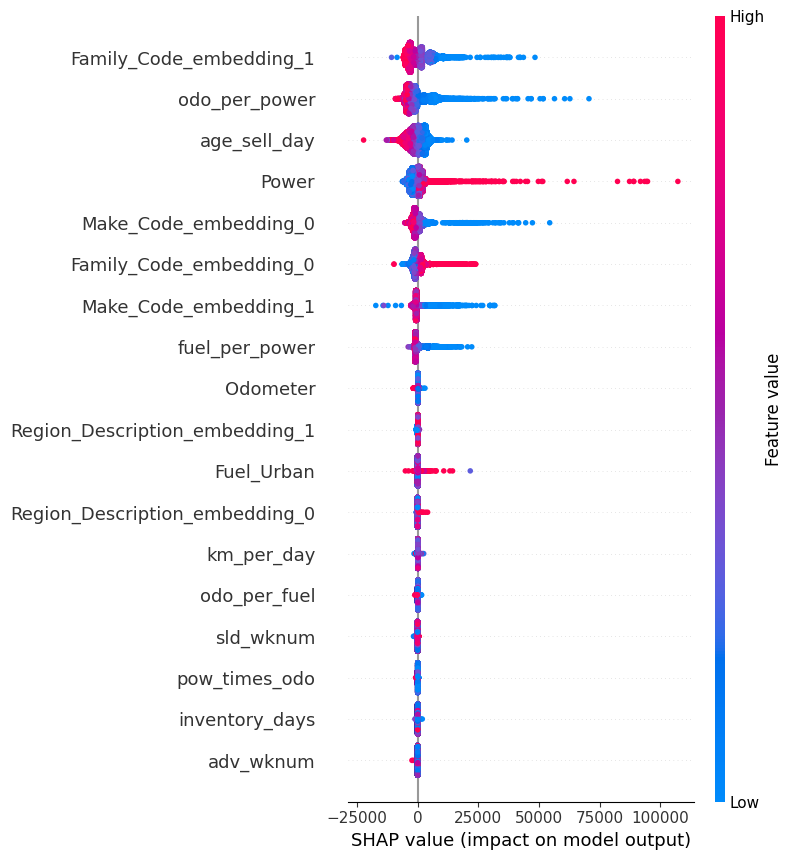

In [31]:
shap.summary_plot(shap_values, Xtest_df)

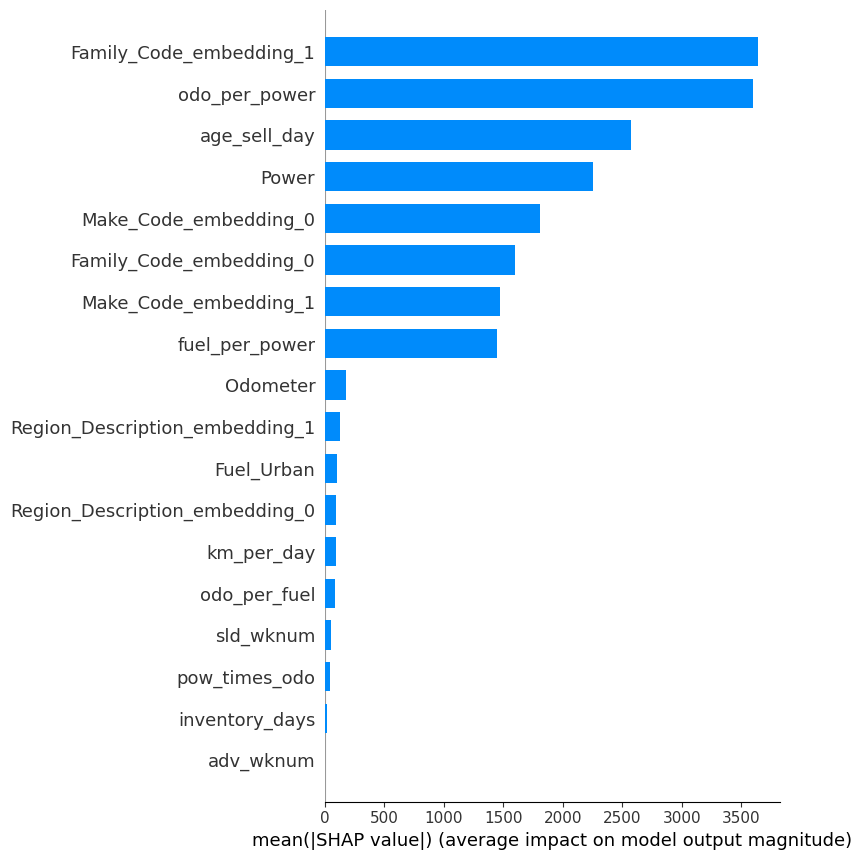

In [32]:
shap.summary_plot(shap_values, Xtest_df, plot_type="bar", show=False)

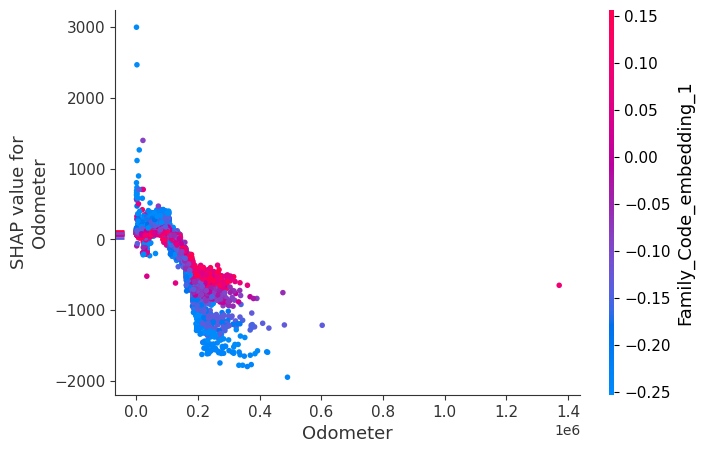

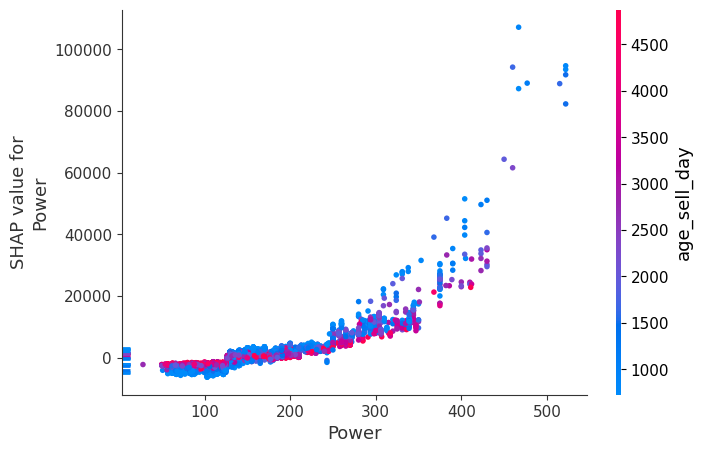

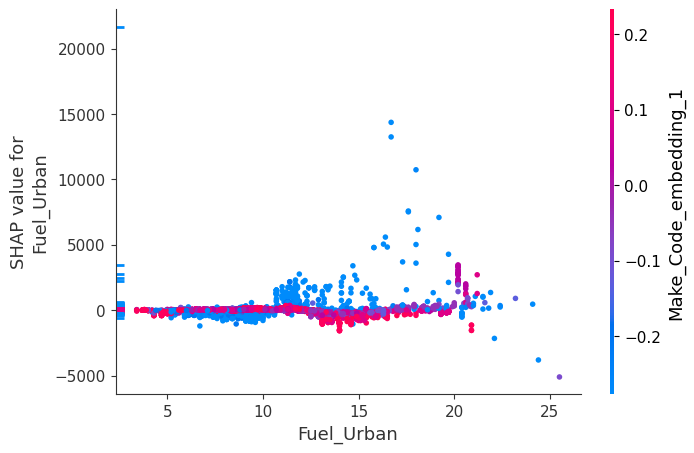

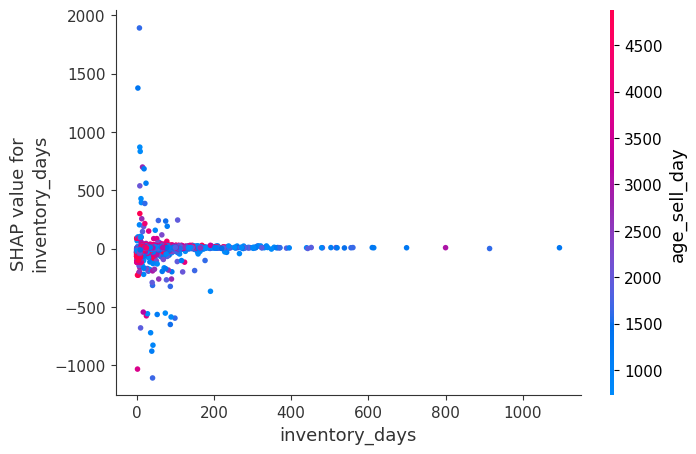

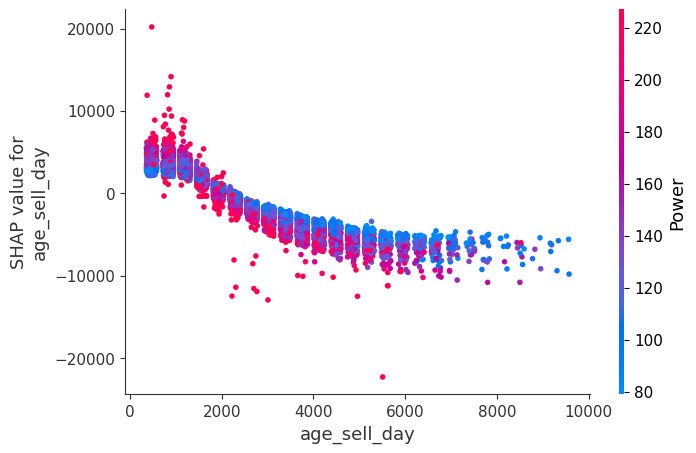

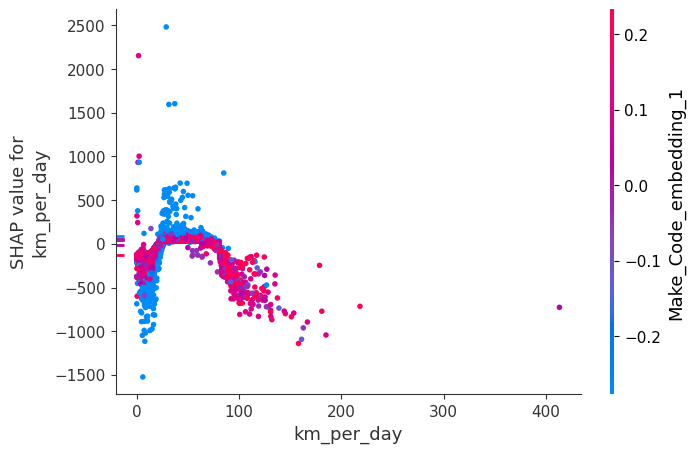

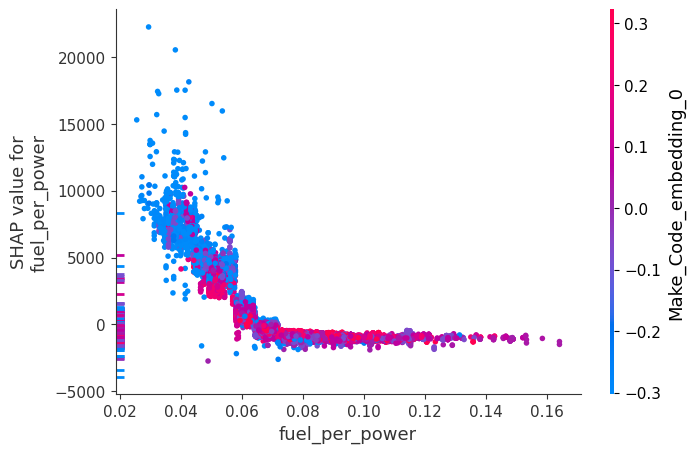

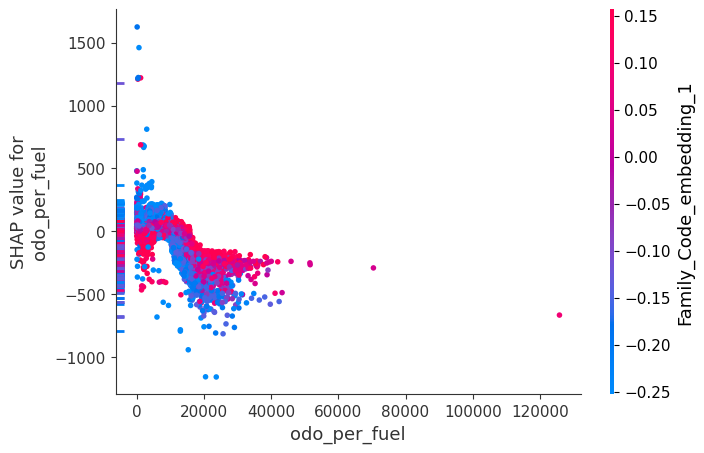

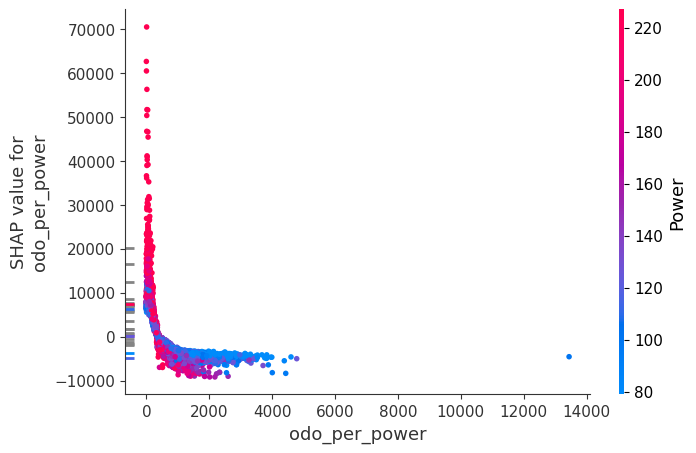

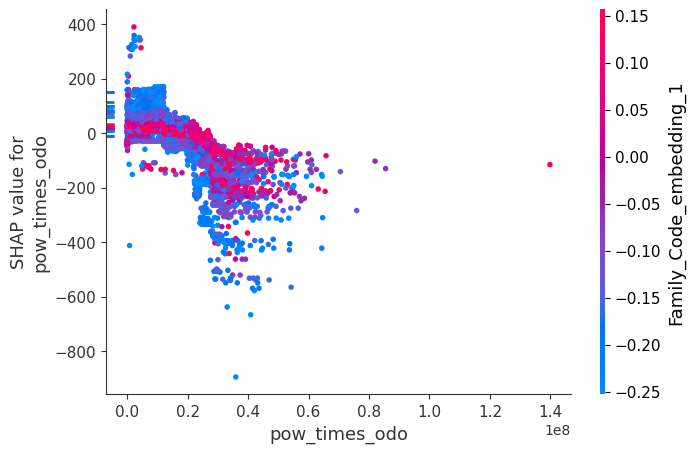

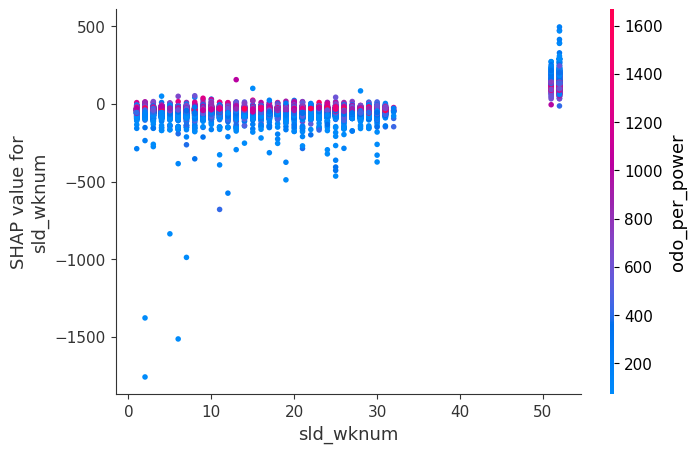

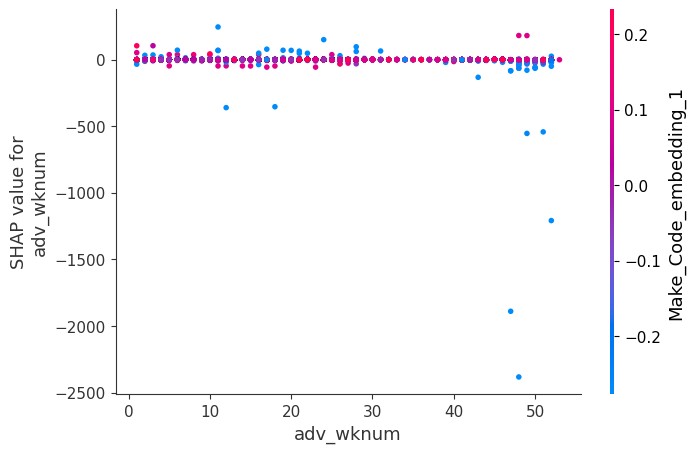

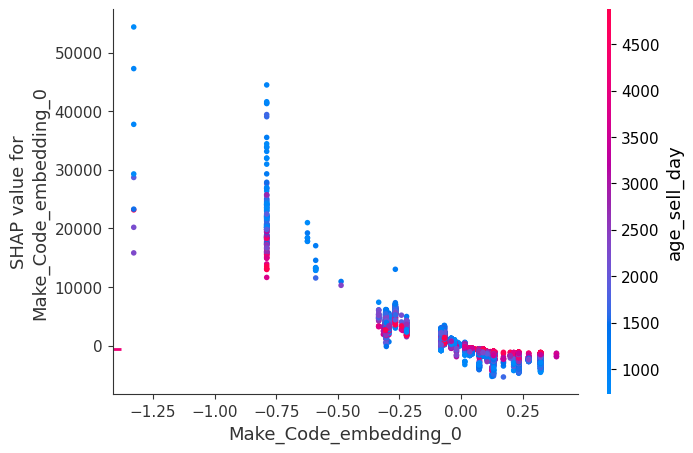

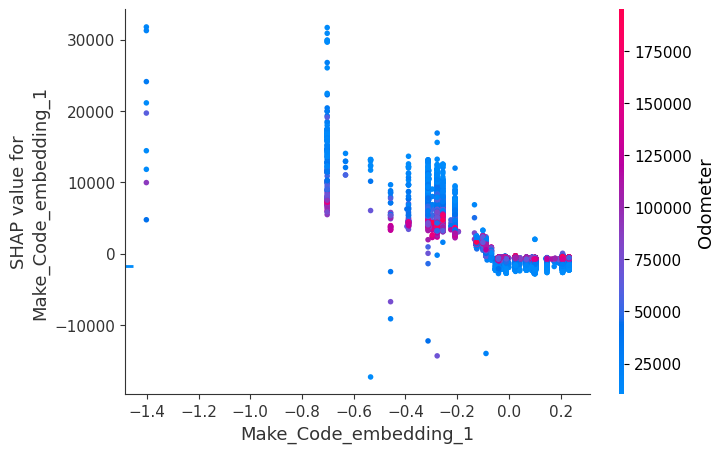

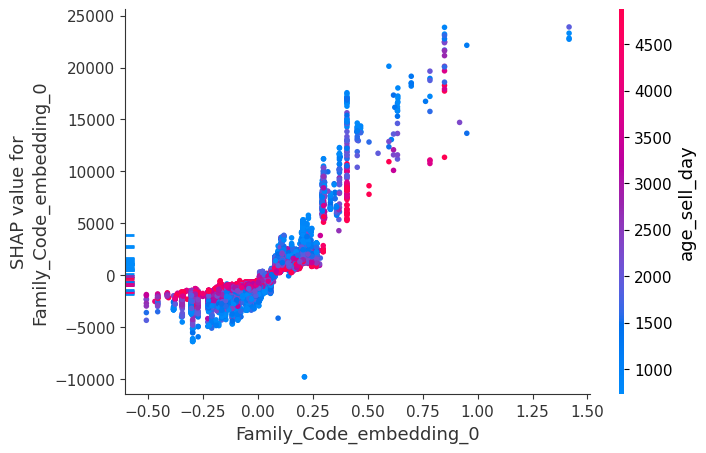

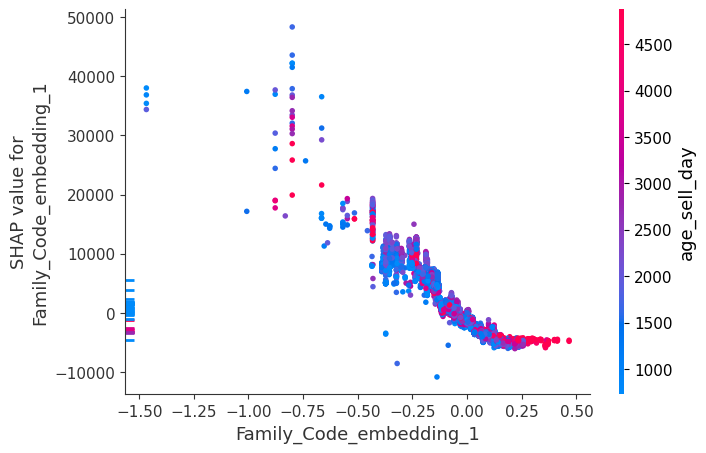

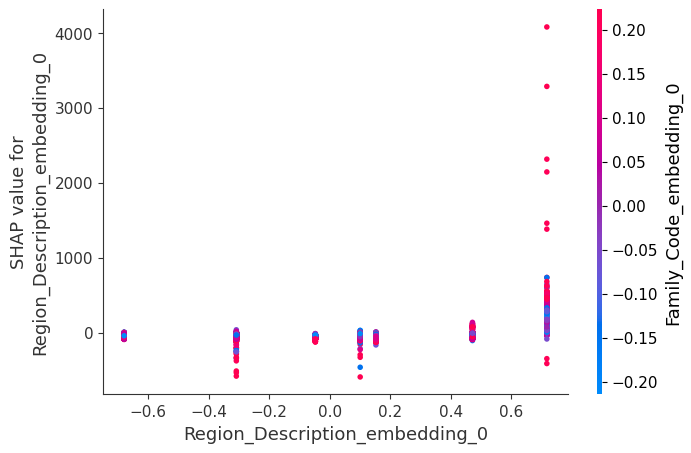

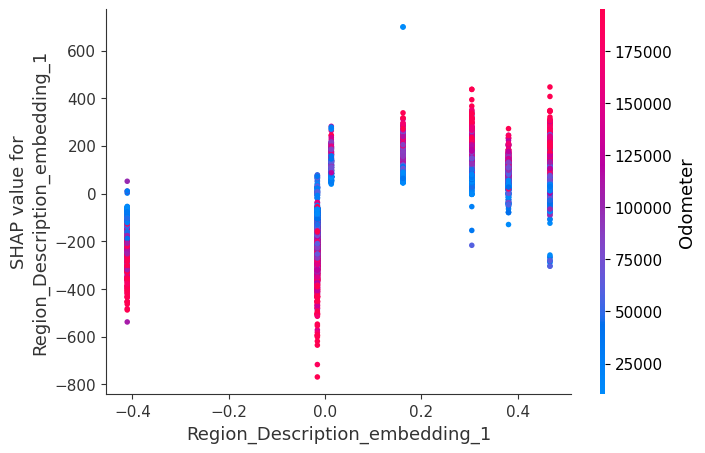

In [33]:
for i in X_test_df.columns:
    shap.dependence_plot(i, shap_values, X_test_df)

In [34]:
n=4
choosen_instance, price = X_test_df.iloc[[n]], y_test.iloc[n]
print(f"Price {price}")
choosen_instance.T

Price 27263.64


,4
Odometer,3.912200e+04
Power,1.270000e+02
Fuel_Urban,8.100000e+00
inventory_days,1.800000e+01
age_sell_day,1.818000e+03
km_per_day,2.151925e+01
fuel_per_power,6.377953e-02
odo_per_fuel,4.829877e+03
odo_per_power,3.080472e+02
pow_times_odo,4.968494e+06


In [35]:
shap_value = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_value, choosen_instance)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
